# 

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from problems import IntegerKnapsack

from circuit_lengths import add_lengths_to_df
from regressor import fit_multi

import quantum_plots as qp
_ = qp.global_setup()

In [13]:
df = pd.read_feather("../../results/int_main2.feather")

df = df.query("qaoa != 'qpe'")

df["method"] = df.qaoa + "_" + df.cost

df = df[np.logical_not(np.isnan(df.n_qubits))]
# df = df[np.logical_or(df.cost == "masked_cost", df.qaoa == "masked_cost")]

df["depth"] = df.depth.astype(int)
df["problem_id"] = df.problem_id.astype(int)

In [14]:
df.method.unique()

array(['masked_cost_default', 'quad_penalty_cost_masked_cost',
       'quad_penalty_full_problem_masked_cost'], dtype=object)

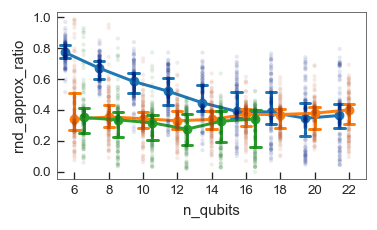

In [15]:
fig, _ = qp.plot_setup()
sns.pointplot(df.query("depth == 4"), x="n_qubits", y="rnd_approx_ratio", hue="method", dodge=.55, legend=False, estimator=np.median, capsize=0.3, errorbar=("pi", 50))
sns.stripplot(df.query("depth == 4"), x="n_qubits", y="rnd_approx_ratio", hue="method", dodge=True, alpha=0.1, legend=False, marker='.', palette="dark", jitter=False)

# plt.yscale("log")
fig.tight_layout()

In [16]:
add_lengths_to_df(df, IntegerKnapsack)

In [17]:
df["adj_clops"] = df.clops * np.ceil(np.log(0.01) / np.log(1 - df.p_opt))
df["log_adj_clops"] = np.log10(df.adj_clops)

df_fit = fit_multi(df, x="n_qubits", y="log_adj_clops", groupby=["method", "depth"])

df_fit

slope  intercept    rvalue  \
method                                depth                                  
masked_cost_default                   1      0.319606   1.852080  0.959573   
                                      2      0.340164   1.592784  0.873682   
                                      3      0.309683   1.638115  0.815176   
                                      4      0.295681   1.582748  0.816917   
                                      6      0.262091   1.676987  0.824364   
                                      8      0.237271   1.816287  0.844481   
                                      12     0.194074   2.132166  0.848262   
                                      16     0.163763   2.367593  0.842899   
                                      24     0.135793   2.605289  0.807466   
                                      32     0.119561   2.756580  0.756378   
                                      48     0.106790   2.920788  0.592043   
                                      64     0.097852   3.045571  0.535815   
quad_penalty_cost_masked_cost         1      0.316354   1.495538  0.913181   
                                      2      0.310510   1.684304  0.848667   
                                      3      0.307514   1.708259  0.814397   
                                      4      0.296799   1.787568  0.769211   
                                      6      0.275931   1.939791  0.679409   
                                      8      0.262610   2.035665  0.636951   
                                      12     0.246348   2.189022  0.583806   
                                      16     0.235338   2.291990  0.557288   
                                      24     0.220777   2.496046  0.518560   
                                      32     0.213961   2.587656  0.501698   
                                      48     0.211798   2.701142  0.430992   
                                      64     0.207415   2.808084  0.410019   
quad_penalty_full_problem_masked_cost 1      0.355280   1.315132  0.932971   
                                      2      0.368691   1.399949  0.890880   
                                      3      0.363623   1.453867  0.844549   
                                      4      0.361020   1.468835  0.808261   
                                      6      0.353352   1.496397  0.751471   
                                      8      0.340886   1.598628  0.699769   
                                      12     0.329450   1.715740  0.643596   
                                      16     0.319076   1.797513  0.593199   
                                      24     0.310710   1.885767  0.539388   
                                      32     0.307706   1.934395  0.514556   
                                      48     0.328774   1.859960  0.218652   
                                      64     0.302169   2.097747  0.173533   

                                                lower     upper  
method                                depth                      
masked_cost_default                   1      0.315810  0.323401  
                                      2      0.332681  0.347648  
                                      3      0.301151  0.318214  
                                      4      0.287583  0.303780  
                                      6      0.255092  0.269091  
                                      8      0.231380  0.243162  
                                      12     0.189325  0.198823  
                                      16     0.159673  0.167854  
                                      24     0.131956  0.139629  
                                      32     0.115635  0.123487  
                                      48     0.100974  0.112605  
                                      64     0.091877  0.103826  
quad_penalty_cost_masked_cost         1      0.310710  0.321997  
                                      2      0.302924  0.318097  
                           

method                                 depth
masked_cost_default                    16       None
quad_penalty_cost_masked_cost          16       None
quad_penalty_full_problem_masked_cost  16       None
dtype: object

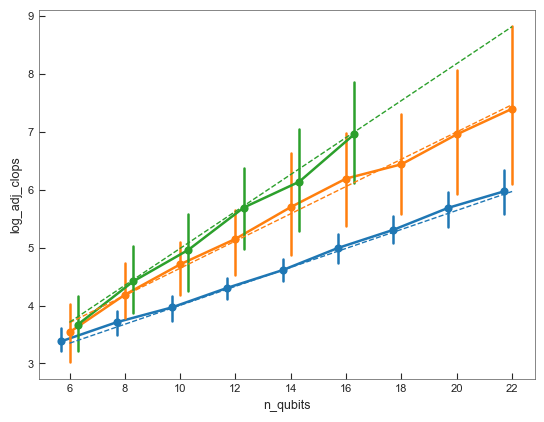

In [21]:
# qp.plot_setup()

sns.pointplot(df.query("depth==16"), x="n_qubits", y="log_adj_clops", hue="method", dodge=0.3, legend=False, errorbar=("pi",50))
# x = np.arange(6, 24, 2)
# plt.plot(x, (0.2829 + 0.005) * x + 1.04)

# plt.yscale("log")



x = np.linspace(6, 22, 100)
xi = np.linspace(0, (22 - 6) / 2, 100)
def plot_fit(d):
    plt.plot(xi,  d.intercept + d.slope * x, linestyle="--")

df_fit.query("depth == 16").apply(plot_fit, axis=1)

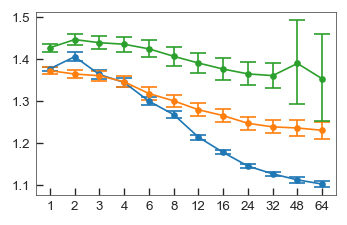

In [22]:
qp.plot_setup()
df_fit["exp_slope"] = np.exp(df_fit.slope)

dfx = df_fit.reset_index()
def plot_method(x):
    bounds = np.abs(np.exp(x[["lower", "upper"]].to_numpy().T) - np.exp(x.slope.to_numpy()[None, :]))
    plt.errorbar(np.arange(len(x.depth)), np.exp(x.slope), yerr=bounds, capsize=5, marker="o")

dfx.groupby("method").apply(plot_method)
_ = plt.xticks(np.arange(len(dfx.depth.drop_duplicates())), dfx.depth.drop_duplicates().astype(int))
# sns.pointplot(df_fit, x="depth", y="slope", hue="method")

,weight_ratio,p_opt,approx_ratio,n_qubits,log_penalty
weight_ratio,1.000000,0.107614,0.638117,-0.018083,-0.196808
p_opt,0.107614,1.000000,0.517345,-0.499095,-0.389938
approx_ratio,0.638117,0.517345,1.000000,-0.126567,-0.576410
n_qubits,-0.018083,-0.499095,-0.126567,1.000000,0.111052
log_penalty,-0.196808,-0.389938,-0.576410,0.111052,1.000000


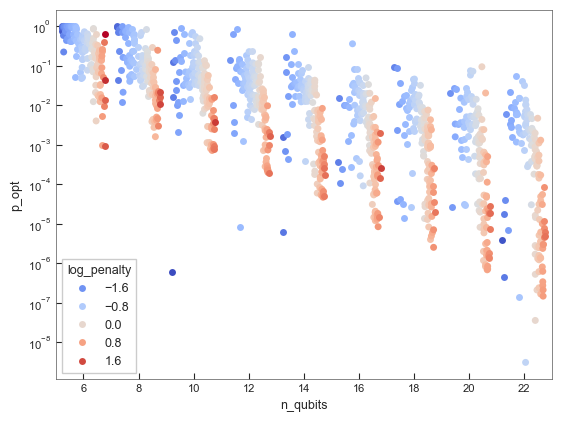

In [23]:
dfx = df[df.qaoa == "quad_penalty_cost"]
dfx = dfx.query("depth == 16")
dfx["log_penalty"] = np.log10(dfx.set_penalty)

sns.stripplot(dfx, x="n_qubits", y="p_opt", hue="log_penalty", palette="coolwarm", dodge=True, jitter=False)
plt.yscale("log")

dfx[["weight_ratio", "p_opt", "approx_ratio", "n_qubits", "log_penalty"]].corr()

In [25]:
instances = IntegerKnapsack.get_instances()[10][:64]

dat = []
for prb in instances:
    r = prb.max_capacity / sum(prb.weights)
    dg = prb.kickback_cost().scale_between_sym()
    dat += [{"id": prb.id, "weight_ratio": r, "value": v} for v in dg.to_numpy()]

In [26]:
df_prb = pd.DataFrame(dat)
df_prb["wrr"] = df.weight_ratio.transform(lambda x: np.round(x, 1))

In [27]:
# sns.histplot(df_prb, x="value", hue="id", alpha=0.1, palette="muted")

In [28]:
dfx.query("set_penalty < 0.02").set_penalty

307      0.007396
739      0.018904
1927     0.017751
1963     0.018904
3583     0.006173
3871     0.013850
4375     0.008395
4771     0.008264
6103     0.017778
6319     0.016790
6499     0.009452
6607     0.015556
9883     0.015625
11227    0.020000
12331    0.004800
12475    0.012346
17323    0.010417
17467    0.012800
19843    0.019722
19939    0.015306
23059    0.017600
28489    0.015625
28889    0.013889
29589    0.005917
Name: set_penalty, dtype: float64

In [29]:
# interesting instances: 40, 44, 45, 
prb = IntegerKnapsack.get_instances()[16][48]

cost, constr = prb.diagonalized()
norm = np.abs(cost.min_val)
cost = cost / norm

cost_arr = cost.to_numpy()

feas = (constr >= 0).to_numpy()

dfu = pd.DataFrame(np.stack([cost_arr, feas]).T, columns=["v", "c"])

<Axes: xlabel='v', ylabel='Count'>

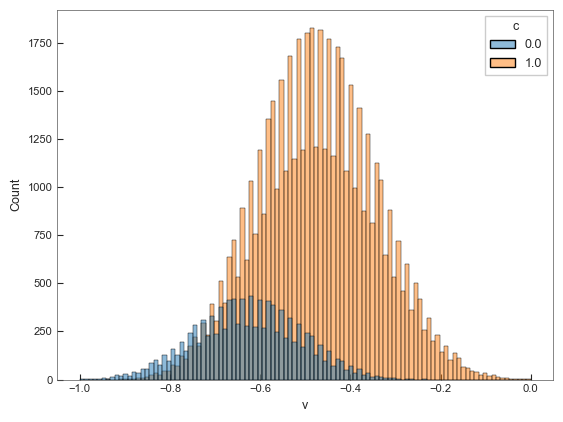

In [30]:
sns.histplot(dfu, x="v", hue="c")
# plt.xlim(-1, -0.8)
# plt.ylim(0, 200)

In [31]:
qpc = prb.quad_penalty_cost() / norm
print(prb._penalty)

dfu2 = pd.DataFrame(np.stack([qpc.to_numpy(), feas]).T, columns=["v", "c"])

0.9999999900000002


<Axes: xlabel='v', ylabel='Count'>

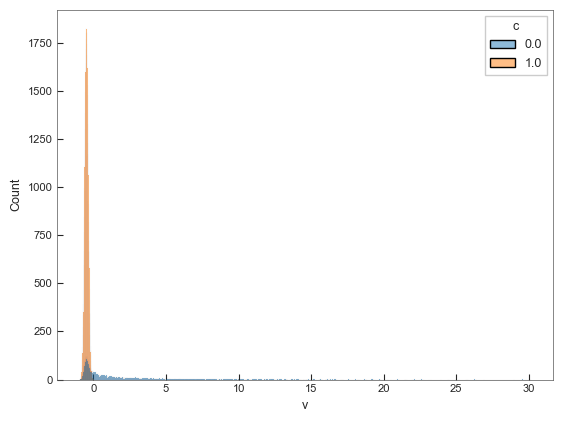

In [32]:
sns.histplot(dfu2, x="v", hue="c")
# plt.xlim(-0.8, -0.6)
# plt.ylim(0, 200)

In [33]:
prb._penalty

0.9999999900000002

In [34]:
df["log_penalty"] = df.set_penalty.transform(lambda x: x if np.isnan(x) else np.log10(x))

In [35]:
df.method

0                          masked_cost_default
1                          masked_cost_default
2                          masked_cost_default
3                          masked_cost_default
4                          masked_cost_default
                         ...                  
34887    quad_penalty_full_problem_masked_cost
34888    quad_penalty_full_problem_masked_cost
34889    quad_penalty_full_problem_masked_cost
34890    quad_penalty_full_problem_masked_cost
34891    quad_penalty_full_problem_masked_cost
Name: method, Length: 34892, dtype: object

## Correlation of instance types

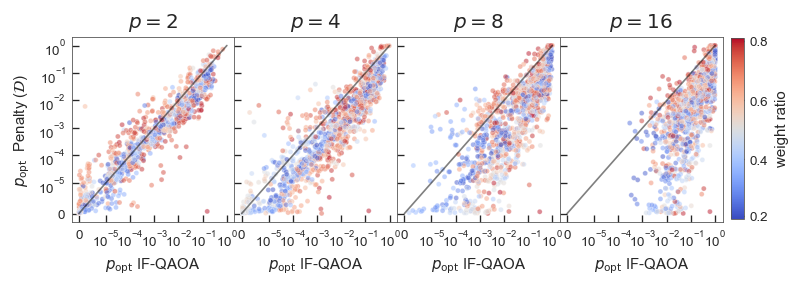

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(7, 2), dpi=120, facecolor="white")
dfp = df.pivot(index=["problem_id", "n_qubits", "depth"], columns="qaoa")
# dfp = dfp.query("n_qubits >= 10")
# dfp["weight_ratio"] = dfp[("weight_ratio", "masked_cost_default")]
# dfp["set_penalty"] = dfp[("set_penalty", "quad_penalty_cost_default")]
# plt.yscale("log")
# plt.xscale("log")



c = "p_opt"
default = lambda x: dfp[(x, "quad_penalty_cost")]

depths = [2, 4, 8, 16]


plots = []
for d, a in zip(depths, ax):
    p = sns.scatterplot(dfp.query("depth == @d"), x=(c, "masked_cost"), y=(c, "quad_penalty_cost"), hue=default("weight_ratio"), alpha=0.5, legend=False, palette="coolwarm", ax=a)
    a.set_title(f"$p = {d}$")
    plots.append(p)

for a in ax:
    a.plot([0, 1], [0, 1], color="k", alpha=0.5)
    #a.set_ylim((0, 1))
    #a.set_xlim((0, 1))
    a.set_yscale("symlog", linthresh=1e-5)
    a.set_xscale("symlog", linthresh=1e-5)
    # a.set_xticks([0.2, 0.5, 0.8])
    a.set_xlabel("$p_\mathrm{opt}$ IF-QAOA")

for a in ax[1:]:
    a.axes.yaxis.set_ticklabels([])
    a.set_ylabel(None)
ax[0].set_ylabel(r"$p_\mathrm{opt}$  Penalty ($\mathcal{D}$)")

plt.subplots_adjust(wspace=0, hspace=0)

ser = default("weight_ratio")

norm = plt.Normalize(ser.min(), ser.max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

cb_ax = fig.add_axes([.91,.124,.015,.754])
fig.colorbar(sm, orientation='vertical', cax=cb_ax, label="weight ratio", ticks=[0.21, 0.4, 0.6, 0.8])

cb_ax.set_yticks([0.21, 0.4, 0.6, 0.8], [0.2, 0.4, 0.6, 0.8])

# fig.tight_layout()

plt.savefig("plots/int_raar_cmp_weight_ratio.pdf", bbox_inches="tight", transparent=True)

energy                    \
qaoa                      masked_cost quad_penalty_cost   
problem_id n_qubits depth                                 
0          6        1      -19.786619        -25.482384   
                    2      -35.038013        -28.974902   
                    3      -52.203761        -36.615877   
                    4      -66.249422        -41.519516   
                    6      -79.716505        -45.023453   
...                               ...               ...   
127        22       8     -210.516722       -163.738807   
                    12    -253.371221       -163.993444   
                    16    -278.676435       -164.392337   
                    24    -302.135623       -164.485739   
                    32    -310.117519       -164.667999   

                                                    approx_ratio  \
qaoa                      quad_penalty_full_problem  masked_cost   
problem_id n_qubits depth                                          
0          6        1                    -25.442909     0.232784   
                    2                    -32.524231     0.412212   
                    3                    -38.148590     0.614162   
                    4                    -40.544512     0.779405   
                    6                    -45.283276     0.937841   
...                                             ...          ...   
127        22       8                           NaN     0.639868   
                    12                          NaN     0.770125   
                    16                          NaN     0.847041   
                    24                          NaN     0.918345   
                    32                          NaN     0.942606   

                                                                       \
qaoa                      quad_penalty_cost quad_penalty_full_problem   
problem_id n_qubits depth                                               
0          6        1              0.299793                  0.299328   
                    2              0.340881                  0.382638   
                    3              0.430775                  0.448807   
                    4              0.488465                  0.476994   
                    6              0.529688                  0.532744   
...                                     ...                       ...   
127        22       8              0.497686                       NaN   
                    12             0.498460                       NaN   
                    16             0.499673                       NaN   
                    24             0.499957                       NaN   
                    32             0.500511                       NaN   

                           feas_ratio                    \
qaoa                      masked_cost quad_penalty_cost   
problem_id n_qubits depth                                 
0          6        1        0.357570          0.708664   
                    2        0.553211          0.788277   
                    3        0.735905          0.783810   
                    4        0.886719          0.764478   
                    6        0.985981          0.758028   
...                               ...               ...   
127        22       8        0.917688          0.957462   
                    12       0.943364          0.959071   
                    16       0.977856          0.964017   
                    24       0.993928          0.964106   
                    32       0.997352          0.965634   

                                                    feas_approx_ratio  ...  \
qaoa                      quad_penalty_full_problem       masked_cost  ...   
problem_id n_qubits depth                                              ...   
0          6        1                      0.742084          0.651016  ...   
                    2                      0.848432          0.745126  ...   
           

ValueError: Length of tuple vectors must match length of `data` when both are used, but `data` has length 13314 and the vector passed to `x` has length 2.

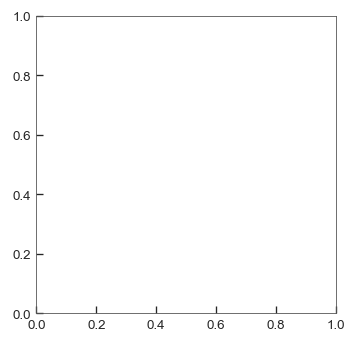

In [62]:
qp.plot_setup(aspect_ratio=1)

c = "energy"
sns.scatterplot(dfp, x=(c, "masked_cost_default"), y=(c, "quad_penalty_cost"), alpha=0.8, legend=False, palette="crest")
plt.plot([0, 1], [0, 1], color="k")

plt.ylim((0, 1))
plt.xlim((0, 1))

plt.xlabel("Indicator Function RAAR")
plt.ylabel("Penalty RAAR")


<Axes: xlabel='depth', ylabel='log_adj_clops'>

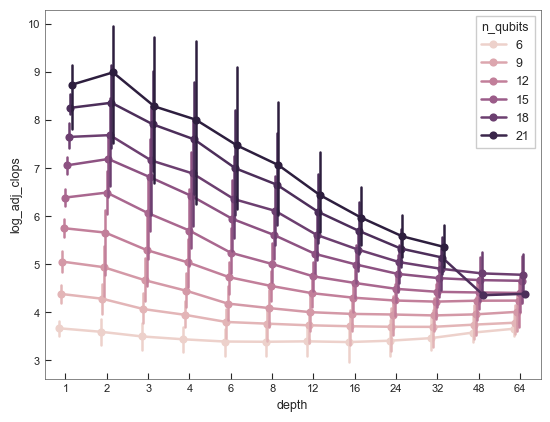

In [49]:
sns.pointplot(df.query("qaoa == 'masked_cost'"), x="depth", y="log_adj_clops", hue="n_qubits", errorbar=("pi", 75), dodge=0.3)

In [50]:
df.query("n_qubits == 22").clops.max()

3616

# Deeper optimal scaling analysis

In [64]:
df2 = pd.read_feather("../../results/int_scaling.feather")
# df2 = df2.query("qaoa == 'masked_cost'")
df2 = df2.query("n_qubits < 18")

In [24]:
add_lengths_to_df(df2, IntegerKnapsack)

In [25]:
df2["adj_clops"] = df2.clops * np.ceil(np.log(0.01) / np.log(1 - df2.p_opt))
df2["log_adj_clops"] = np.log10(df2.adj_clops)

In [81]:
# df3 = pd.concat([df, df2])
df3 = df.query("depth <= 32")
df2 = df3

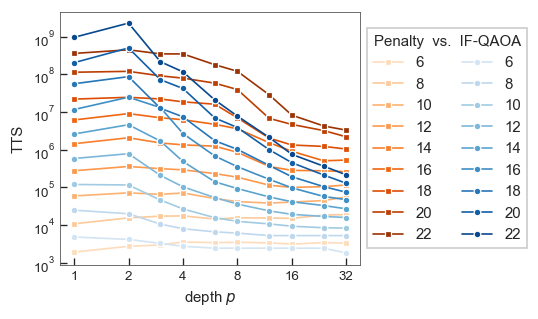

In [83]:


_, ax = qp.plot_setup(aspect_ratio=0.85)

# sns.lineplot(df2.query("qaoa == 'masked_cost'"), x="depth", y="adj_clops", hue="n_qubits", errorbar=("pi", 50), marker="o", palette="Blues")
p = sns.color_palette("Oranges", 10)[1:]
sns.lineplot(df3.query("qaoa == 'quad_penalty_cost'"), x="depth", y="adj_clops", hue="n_qubits", palette=p, legend=True, marker="s", markersize=4, estimator=lambda x: np.quantile(x, 0.5), errorbar=None)

p = sns.color_palette("Blues", 10)[1:]
tgt = sns.lineplot(df3.query("qaoa == 'masked_cost'"), x="depth", y="adj_clops", hue="n_qubits", palette=p, marker="o", markersize=4, estimator=lambda x: np.quantile(x, 0.5), errorbar=None)


plt.yscale("log")
plt.ylabel("TTS")

plt.xlabel("depth $p$")

# plt.xlim(0, 32)
x, y = ax.get_legend_handles_labels()
ax.legend_.remove()

plt.xscale("log")

plt.xticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])


ax.legend(x + x, y, ncols=2, title="Penalty  vs.  IF-QAOA", loc="center left", bbox_to_anchor=(1, 0.5))

plt.savefig("plots/int_clops.pdf", bbox_inches="tight", transparent=True)

In [84]:
df2["tot_iterations"] = df2.groupby(["n_qubits", "problem_id", "qaoa"]).iterations.cumsum()

df2["it_clops"] = df2.clops * df2.iterations

df2["tot_it_clops"] = df2.groupby(["n_qubits", "problem_id", "qaoa"]).it_clops.cumsum()

/var/folders/0y/wbcxhvy92xz19jsf8x4s17km0000gn/T/ipykernel_8646/1829898713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["tot_iterations"] = df2.groupby(["n_qubits", "problem_id", "qaoa"]).iterations.cumsum()
/var/folders/0y/wbcxhvy92xz19jsf8x4s17km0000gn/T/ipykernel_8646/1829898713.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["it_clops"] = df2.clops * df2.iterations
/var/folders/0y/wbcxhvy92xz19jsf8x4s17km0000gn/T/ipykernel_8646/1829898713.py:5: SettingWithCopyWarning: 
A value is tryi

/var/folders/0y/wbcxhvy92xz19jsf8x4s17km0000gn/T/ipykernel_8646/940431638.py:7: UserWarning: 
The palette list has fewer values (6) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(df2.query("qaoa == 'quad_penalty_cost'"), x="depth", y=y, hue="n_qubits", palette=p, legend=True, marker="s", markersize=4, estimator=np.median)
/var/folders/0y/wbcxhvy92xz19jsf8x4s17km0000gn/T/ipykernel_8646/940431638.py:10: UserWarning: 
The palette list has fewer values (6) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(df2.query("qaoa == 'masked_cost'"), x="depth", y=y, hue="n_qubits", palette=p, legend=True, marker="s", markersize=4, estimator=np.median)


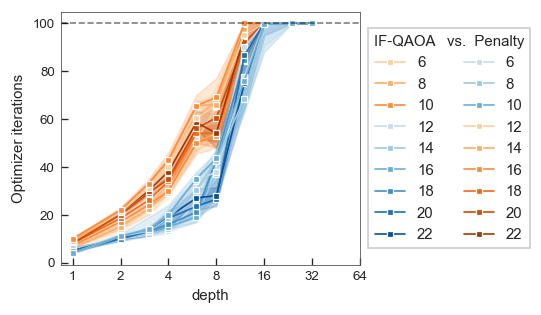

In [85]:
_, ax = qp.plot_setup(aspect_ratio=0.85)


y = "iterations"

p = sns.color_palette("Oranges", 7)[1:]
sns.lineplot(df2.query("qaoa == 'quad_penalty_cost'"), x="depth", y=y, hue="n_qubits", palette=p, legend=True, marker="s", markersize=4, estimator=np.median)

p = sns.color_palette("Blues", 7)[1:]
sns.lineplot(df2.query("qaoa == 'masked_cost'"), x="depth", y=y, hue="n_qubits", palette=p, legend=True, marker="s", markersize=4, estimator=np.median)

plt.xscale("log")

plt.axhline(y=100, linestyle="--", color="k", alpha=0.5)

plt.ylabel("Optimizer iterations")

x, y = ax.get_legend_handles_labels()
ax.legend(x[6:] + x[:6], y, ncols=2, title="IF-QAOA   vs.  Penalty", loc="center left", bbox_to_anchor=(1, 0.5))

plt.xticks([1, 2, 4, 8, 16, 32, 64], [1, 2, 4, 8, 16, 32, 64]);

# plt.yscale("log")

plt.savefig("plots/int_iters.pdf", bbox_inches="tight", transparent=True)

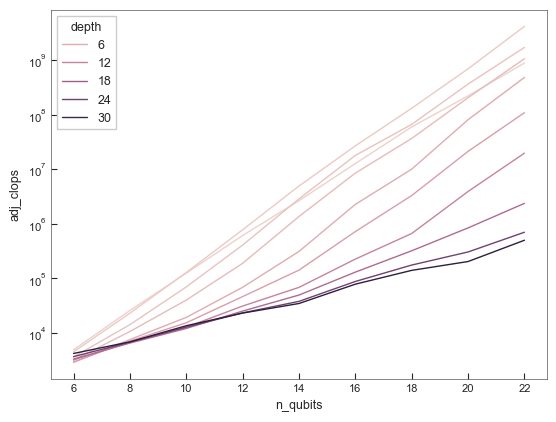

In [86]:
sns.lineplot(df2.query("qaoa == 'masked_cost'"), x="n_qubits", y="adj_clops", hue="depth", errorbar=None)
plt.yscale("log")

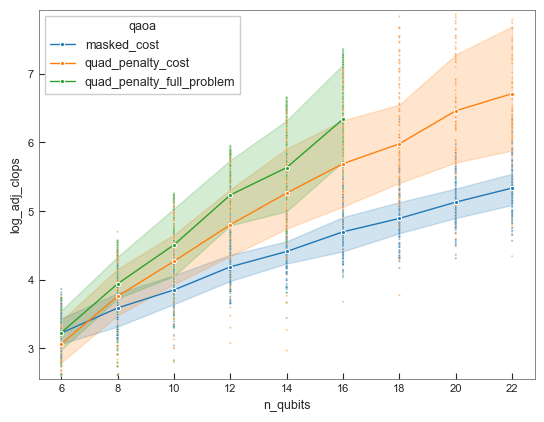

In [87]:
def func(x):
    return x.iloc[x.adj_clops.argmin()]
dfx = df2.groupby(["n_qubits", "problem_id", "qaoa"]).apply(func)

sns.lineplot(dfx, x="n_qubits", y="log_adj_clops", errorbar=("pi", 50), marker='o', hue="qaoa")
ylim = plt.gca().get_ylim()
sns.scatterplot(dfx, x="n_qubits", y="log_adj_clops", alpha=0.5, marker='.', hue="qaoa", legend=False)
plt.ylim(ylim)
# plt.xscale("log")

x = np.linspace(0, 64)

# plt.xscale("log")

# plt.plot(x, np.log10(x))


In [88]:
import statsmodels.formula.api as smf

In [89]:
reg = smf.ols("np.log(adj_clops) ~ np.log(n_qubits)", data=dfx.query("qaoa == 'masked_cost'")).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(adj_clops)   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     4886.
Date:                Fri, 25 Oct 2024   Prob (F-statistic):               0.00
Time:                        10:57:31   Log-Likelihood:                -1305.8
No. Observations:                1152   AIC:                             2616.
Df Residuals:                    1150   BIC:                             2626.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4229      0.140      3.029      0.003       0.149       0.697
np.log(n_qubits)     3.7634      0.054     69.898      0.000       3.658       3.869
==============================================================================
Omnibus:                       31.357   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.492
Skew:                           0.391   Prob(JB):                     5.34e-08
Kurtosis:                       3.296   Cond. No.                         18.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
reg = smf.ols("depth ~ n_qubits", data=dfx).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  depth   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     463.7
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           6.73e-96
Time:                        10:57:31   Log-Likelihood:                -12031.
No. Observations:                3072   AIC:                         2.407e+04
Df Residuals:                    3070   BIC:                         2.408e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6722      0.626      7.468      0.000       3.446       5.899
n_qubits       0.9522      0.044     21.533      0.000       0.865       1.039
==============================================================================
Omnibus:                     4788.799   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.597
Skew:                          -0.130   Prob(JB):                     1.13e-46
Kurtosis:                       1.741   Cond. No.                         40.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
adj_clops2 = df2.groupby(["n_qubits", "depth"])["adj_clops"].mean()

In [92]:
adj_clops2.reset_index().groupby("n_qubits")

In [93]:
df_fit = fit_multi(pd.concat([df.query("qaoa == 'quad_penalty_full_problem'"), df2]), x="n_qubits", y="log_adj_clops", groupby=["qaoa", "depth"])

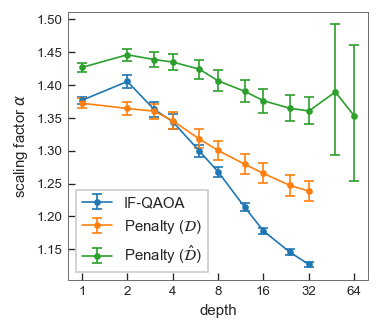

In [94]:
qp.plot_setup(aspect_ratio=0.9)
df_fit["exp_slope"] = np.exp(df_fit.slope)

dfx = df_fit.reset_index()
def plot_method(x):
    bounds = np.abs(np.exp(x[["lower", "upper"]].to_numpy().T) - np.exp(x.slope.to_numpy()[None, :]))
    plt.errorbar(x.depth, np.exp(x.slope), yerr=bounds, capsize=3, marker="o")

dfx.groupby("qaoa").apply(plot_method)

plt.xscale("log")

plt.legend(["IF-QAOA", "Penalty ($\mathcal{D}$)", "Penalty ($\hat{\mathcal{D}}$)"])

plt.ylabel(r"scaling factor $\alpha$")
plt.xlabel("depth")
plt.xticks([1 << i for i in range(7)], [1 << i for i in range(7)]);
# sns.pointplot(df_fit, x="depth", y="slope", hue="method")

plt.savefig("plots/int_scaling.pdf", bbox_inches="tight", transparent=True)

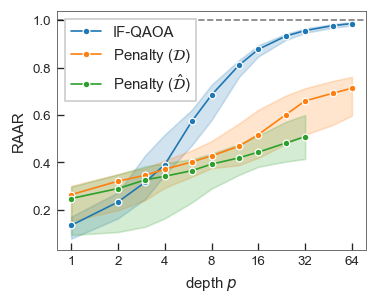

In [95]:
dfx = pd.concat([df2, df])

fig, ax = qp.plot_setup(aspect_ratio=0.8)
pl = sns.lineplot(dfx.query("n_qubits == 16"), x="depth", y="rnd_approx_ratio", hue="qaoa", errorbar=("pi", 50), marker="o", estimator=np.median, legend=True, markersize=4)
# sns.stripplot(dfx.query("n_qubits == 16"), x="depth", y="rnd_approx_ratio", hue="qaoa", dodge=True, alpha=0.1, legend=False, marker='.', palette="dark", jitter=False)

plt.axhline(1, color="k", linestyle="--", alpha=0.5)

plt.xscale("log")

plt.ylabel("RAAR")

h, _ = ax.get_legend_handles_labels()
plt.legend(h, ["IF-QAOA", "Penalty ($\mathcal{D}$)", "Penalty ($\hat{\mathcal{D}}$)"], loc="upper left")

plt.xticks([1, 2, 4, 8, 16, 32, 64], [1, 2, 4, 8, 16, 32, 64])

# plt.yscale("log")
fig.tight_layout()

plt.xlabel("depth $p$")

plt.savefig("plots/cmp_16.pdf", bbox_inches="tight", transparent=True)

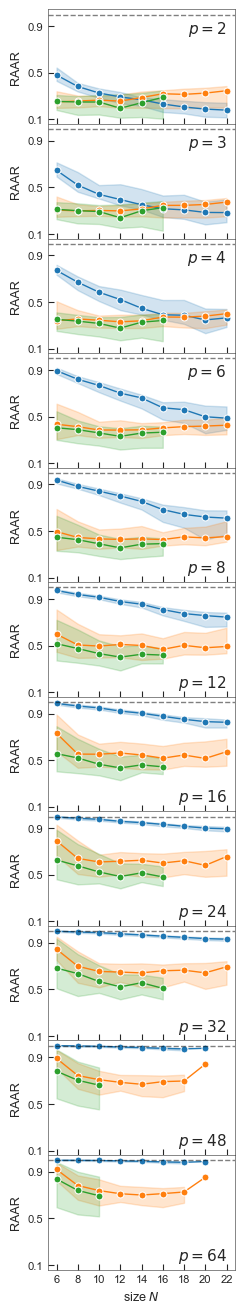

In [96]:
fg = sns.FacetGrid(df.query("depth > 1"), col="depth", aspect=2.1, height=1.2, despine=False, col_wrap=1)


fg.map_dataframe(sns.lineplot, x="n_qubits", y="rnd_approx_ratio", hue="qaoa", errorbar=("pi", 50), estimator=np.median, marker="o", markersize=5)
fg.set_ylabels("RAAR")
fg.map(plt.axhline, y=1, ls="--", c="k", alpha=0.5)
fg.set(yticks=(0.1, 0.5, 0.9))
fg.set(xticks=(6, 8, 10, 12, 14, 16, 18, 20, 22))
fg.set_titles("")

def pl_title(x, **_):
    d = x.iloc[0]
    if d < 8:
        v = 0.8
    else:
        v = 0.1
    plt.text(22, v, f"$p = {d}$", horizontalalignment="right", verticalalignment="bottom", fontsize=11)

fg.map(pl_title, "depth")
fg.set_xlabels("size $N$")
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig("plots/cmp_multi.pdf", bbox_inches="tight", transparent=True)

In [97]:
grid.fig.subplots_adjust(top=0.90)

NameError: name 'grid' is not defined

/var/folders/0y/wbcxhvy92xz19jsf8x4s17km0000gn/T/ipykernel_8646/3813219902.py:1: RuntimeWarning: Mean of empty slice.
  plt.plot(np.array(list(df2.query("qaoa == 'quad_penalty_cost' and n_qubits == 10 and depth == 64").betas)).mean(axis=0))
/Users/david/Library/Caches/pypoetry/virtualenvs/fast-qaoa-TFZnPat--py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


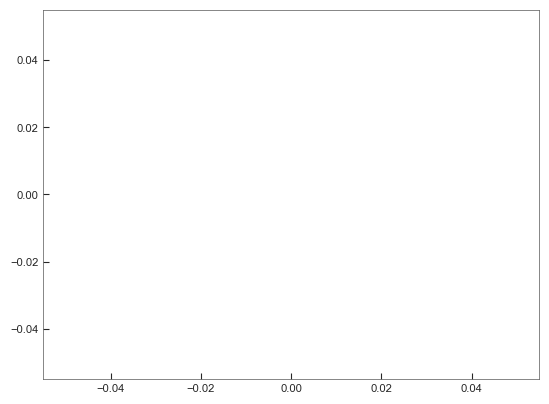

In [98]:
plt.plot(np.array(list(df2.query("qaoa == 'quad_penalty_cost' and n_qubits == 10 and depth == 64").betas)).mean(axis=0))

In [99]:
df2.status

0                    Success
1                    Success
2                    Success
3                    Success
4                    Success
                ...         
34887                Success
34888                Success
34889    ErrMaximumIteration
34890    ErrMaximumIteration
34891    ErrMaximumIteration
Name: status, Length: 30720, dtype: object

/var/folders/0y/wbcxhvy92xz19jsf8x4s17km0000gn/T/ipykernel_8646/3305194692.py:13: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.lineplot(dfx.query("qaoa == 'masked_cost'"), ax=ax[0], x="pdepth", y="gammas", hue="depth", palette=sns.color_palette("flare", len(depths)), marker="o", markersize=4, errorbar="sd", err_kws={"alpha": 0.1})
/var/folders/0y/wbcxhvy92xz19jsf8x4s17km0000gn/T/ipykernel_8646/3305194692.py:14: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.lineplot(dfx.query("qaoa == 'masked_cost'"), ax=ax[0], x="pdepth", y="betas", hue="depth", palette=sns.color_palette("crest", len(depths)), marker="s", markersize=4, errorbar="sd", err_kws={"alpha": 0.1})
/var/folders/0y/wbcxhvy92xz19jsf8x4s17km0000gn/T/ipykernel_8646/3305194692.py:16: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.lineplot(dfx.query("qaoa == 'quad_penalty_c

(0.0, 1.0)

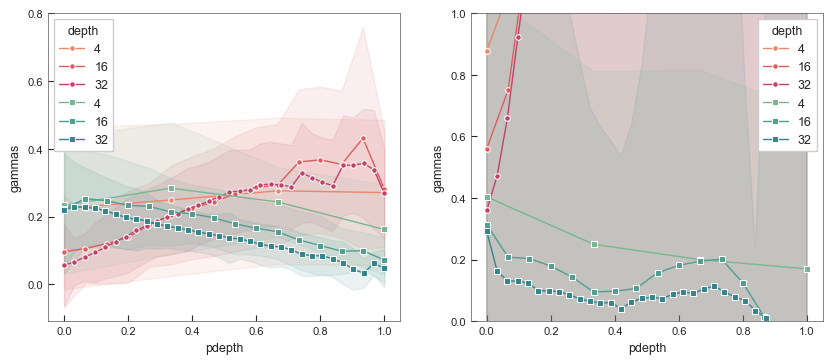

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

dfx = df2[["problem_id", "n_qubits", "depth", "qaoa", "betas", "gammas"]].copy()

dfx["pdepth"] = dfx.depth.transform(lambda d: np.linspace(0, 1, d))

dfx = dfx.explode(column=["betas", "gammas", "pdepth"])

depths = [4, 9, 16, 32, 64]

dfx = dfx.query("depth in @depths")

sns.lineplot(dfx.query("qaoa == 'masked_cost'"), ax=ax[0], x="pdepth", y="gammas", hue="depth", palette=sns.color_palette("flare", len(depths)), marker="o", markersize=4, errorbar="sd", err_kws={"alpha": 0.1})
sns.lineplot(dfx.query("qaoa == 'masked_cost'"), ax=ax[0], x="pdepth", y="betas", hue="depth", palette=sns.color_palette("crest", len(depths)), marker="s", markersize=4, errorbar="sd", err_kws={"alpha": 0.1})

sns.lineplot(dfx.query("qaoa == 'quad_penalty_cost'"), ax=ax[1], x="pdepth", y="gammas", hue="depth", palette=sns.color_palette("flare", len(depths)), marker="o", markersize=4, errorbar="sd", err_kws={"alpha": 0.1})
sns.lineplot(dfx.query("qaoa == 'quad_penalty_cost'"), ax=ax[1], x="pdepth", y="betas", hue="depth", palette=sns.color_palette("crest", len(depths)), marker="s", markersize=4, errorbar="sd", err_kws={"alpha": 0.1})

ax[1].set_ylim((0, 1))

# sns.lineplot(dfx.query("and n_qubits == 16 and qaoa == 'masked_cost'"), x="pdepth", y="gammas")